In [1]:
from IPython.display import Markdown, display

display(Markdown("# 06_city_comparison.ipynb"))
display(Markdown("### Philippine Temperature Analysis (2010–present) — City Comparison"))
display(Markdown("""
This notebook performs **comparative analysis between cities**, including:
- Temperature trends over time
- Seasonal differences
- Extremes and anomalies
- Correlation patterns between cities
"""))

# 06_city_comparison.ipynb

### Philippine Temperature Analysis (2010–present) — City Comparison


This notebook performs **comparative analysis between cities**, including:
- Temperature trends over time
- Seasonal differences
- Extremes and anomalies
- Correlation patterns between cities


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_style("whitegrid")

In [3]:
data_path = "../data/processed/phil_temp_2010_2024.csv"
df = pd.read_csv(data_path)

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['year'] = df['datetime'].dt.year

display(df.head())
display(df.info())
display(df.isna().sum())
display(f"Duplicate rows: {df.duplicated().sum()}")

,city_name,datetime,temperature_2m_mean,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,year
0,Alaminos,2010-01-01,26.6,29.9,24.8,32.0,26.5,2010
1,Alaminos,2010-01-02,26.7,29.4,25.0,32.1,27.4,2010
2,Alaminos,2010-01-03,26.0,27.6,24.5,30.9,28.6,2010
3,Alaminos,2010-01-04,25.9,28.8,23.1,33.6,27.5,2010
4,Alaminos,2010-01-05,26.4,28.5,24.5,33.7,28.8,2010


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552212 entries, 0 to 552211
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   city_name                 552212 non-null  object        
 1   datetime                  552212 non-null  datetime64[ns]
 2   temperature_2m_mean       552212 non-null  float64       
 3   temperature_2m_max        552212 non-null  float64       
 4   temperature_2m_min        552212 non-null  float64       
 5   apparent_temperature_max  500324 non-null  float64       
 6   apparent_temperature_min  500324 non-null  float64       
 7   year                      552212 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(1), object(1)
memory usage: 31.6+ MB


None

city_name                       0
datetime                        0
temperature_2m_mean             0
temperature_2m_max              0
temperature_2m_min              0
apparent_temperature_max    51888
apparent_temperature_min    51888
year                            0
dtype: int64

'Duplicate rows: 0'

In [4]:
top_cities = df['city_name'].value_counts().index[:5]
display(Markdown(f"### Top Cities Selected for Comparison: {list(top_cities)}"))

### Top Cities Selected for Comparison: ['Alaminos', 'Pagadian', 'Naga', 'Navotas', 'Olongapo']

In [5]:
city_stats = df[df['city_name'].isin(top_cities)].groupby('city_name').agg({
    'temperature_2m_mean':['mean','min','max','std'],
    'temperature_2m_max':['mean','min','max','std'],
    'temperature_2m_min':['mean','min','max','std']
}).round(2)

display(city_stats)
display(Markdown("""
**Observations:**
- Cities with highest mean temperature can be identified.
- Std deviation shows variability in temperature per city.
"""))

temperature_2m_mean                     temperature_2m_max         \
                         mean    min    max   std               mean    min   
city_name                                                                     
Alaminos                27.33  23.30  31.20  1.23              29.74  24.40   
Naga                    26.47  23.62  31.31  0.91              28.79  23.62   
Navotas                 26.65  21.50  32.79  1.42              28.84  22.70   
Olongapo                27.40  23.03  33.03  1.30              29.73  23.03   
Pagadian                26.64  22.31  30.65  1.02              28.55  22.31   

                      temperature_2m_min                     
            max   std               mean   min    max   std  
city_name                                                    
Alaminos   37.6  2.05              25.56  20.2  30.78  1.35  
Naga       33.0  1.52              24.65  21.3  31.31  0.96  
Navotas    35.6  1.90              25.09  18.8  31.75  1.42  
Olongapo   35.6  1.95              25.58  21.0  33.03  1.38  
Pagadian   34.5  1.72              25.06  20.4  30.65  0.90


**Observations:**
- Cities with highest mean temperature can be identified.
- Std deviation shows variability in temperature per city.


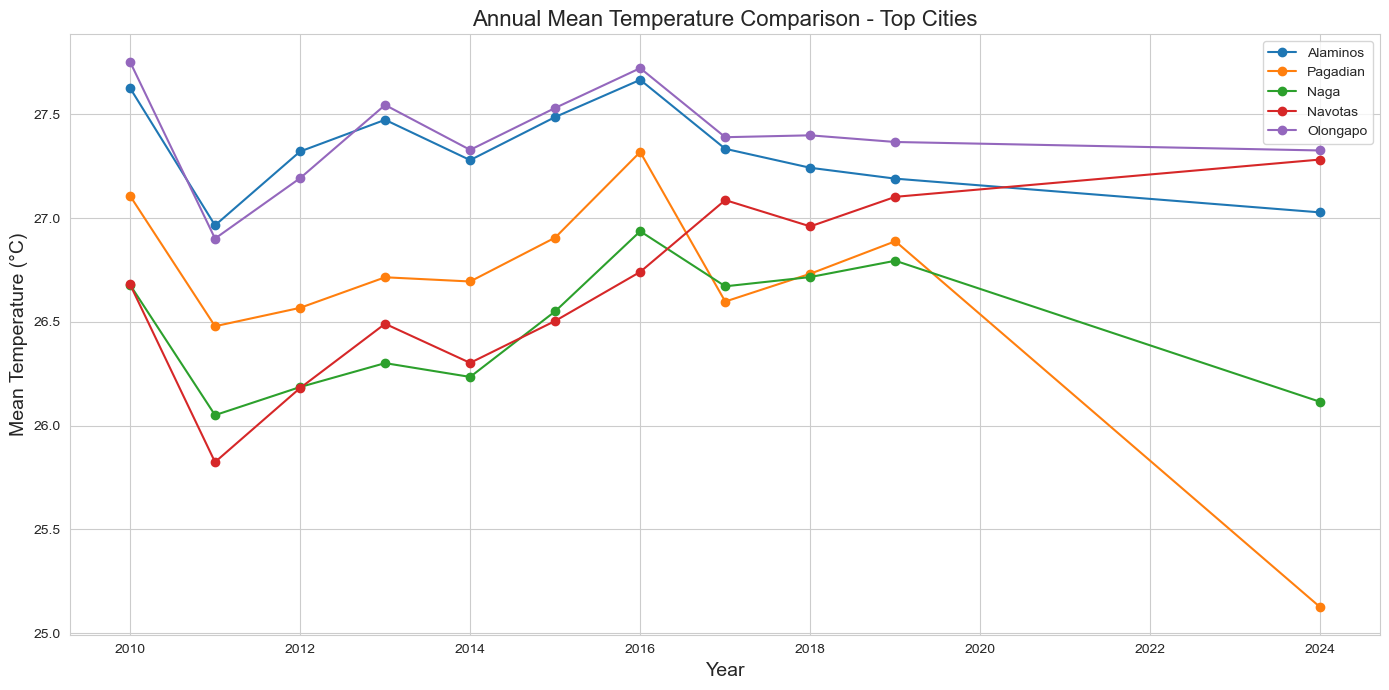

In [6]:
annual_city = df[df['city_name'].isin(top_cities)].groupby(['city_name','year']).agg({
    'temperature_2m_mean':'mean'
}).reset_index()

plt.figure(figsize=(14,7))
for city in top_cities:
    city_data = annual_city[annual_city['city_name']==city]
    plt.plot(city_data['year'], city_data['temperature_2m_mean'], marker='o', label=city)

plt.title("Annual Mean Temperature Comparison - Top Cities", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Temperature (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

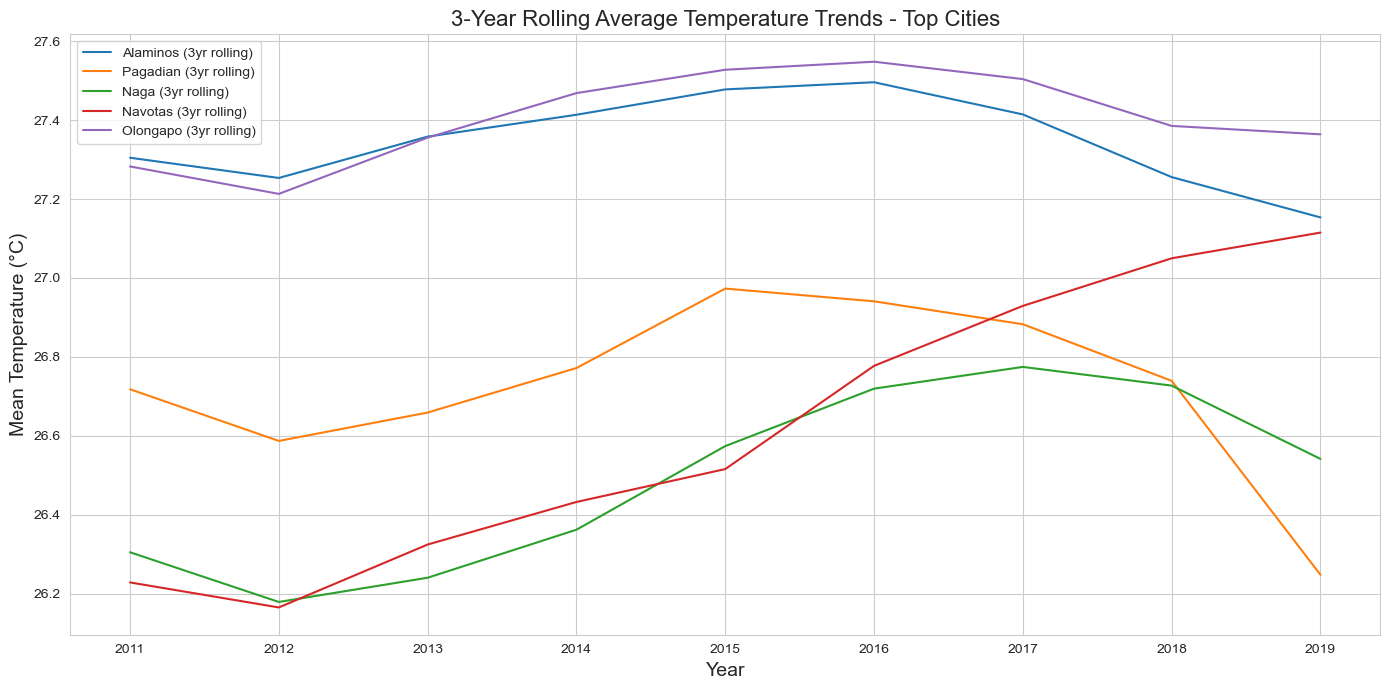

In [7]:
plt.figure(figsize=(14,7))
for city in top_cities:
    city_data = annual_city[annual_city['city_name']==city].copy()
    city_data['rolling_3yr'] = city_data['temperature_2m_mean'].rolling(3, center=True).mean()
    plt.plot(city_data['year'], city_data['rolling_3yr'], label=f"{city} (3yr rolling)")

plt.title("3-Year Rolling Average Temperature Trends - Top Cities", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Temperature (°C)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

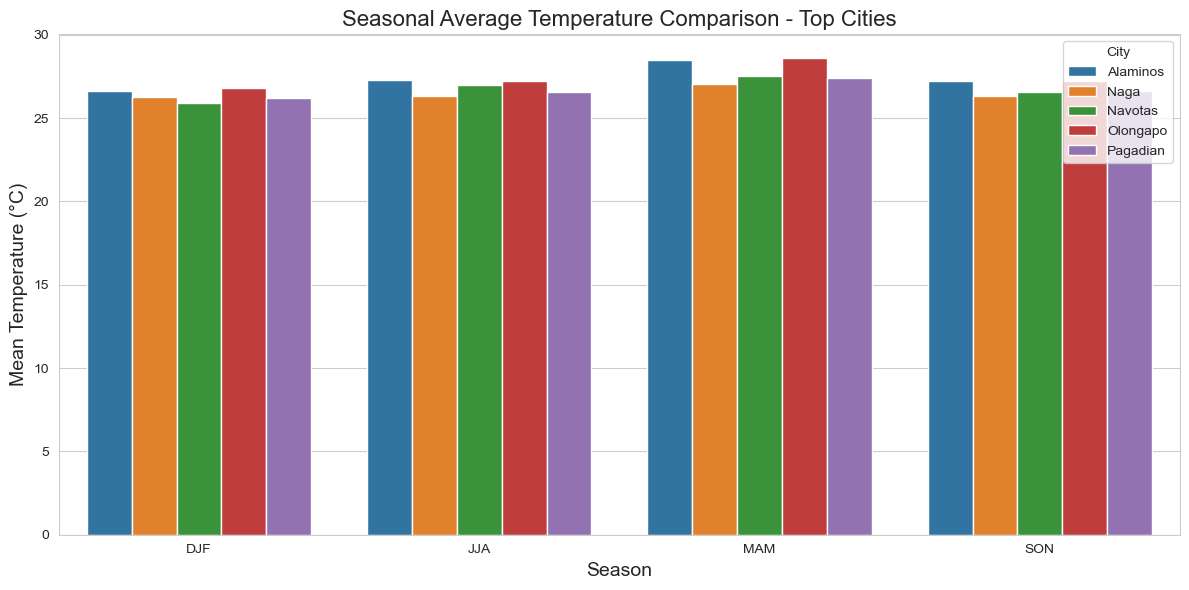

In [8]:
def month_to_season(month):
    if month in [12,1,2]: return 'DJF'
    elif month in [3,4,5]: return 'MAM'
    elif month in [6,7,8]: return 'JJA'
    else: return 'SON'

df['month'] = df['datetime'].dt.month
df['season'] = df['month'].apply(month_to_season)

season_city = df[df['city_name'].isin(top_cities)].groupby(['city_name','season']).agg({
    'temperature_2m_mean':'mean'
}).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=season_city, x='season', y='temperature_2m_mean', hue='city_name')
plt.title("Seasonal Average Temperature Comparison - Top Cities", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Mean Temperature (°C)", fontsize=14)
plt.legend(title='City')
plt.tight_layout()
plt.show()

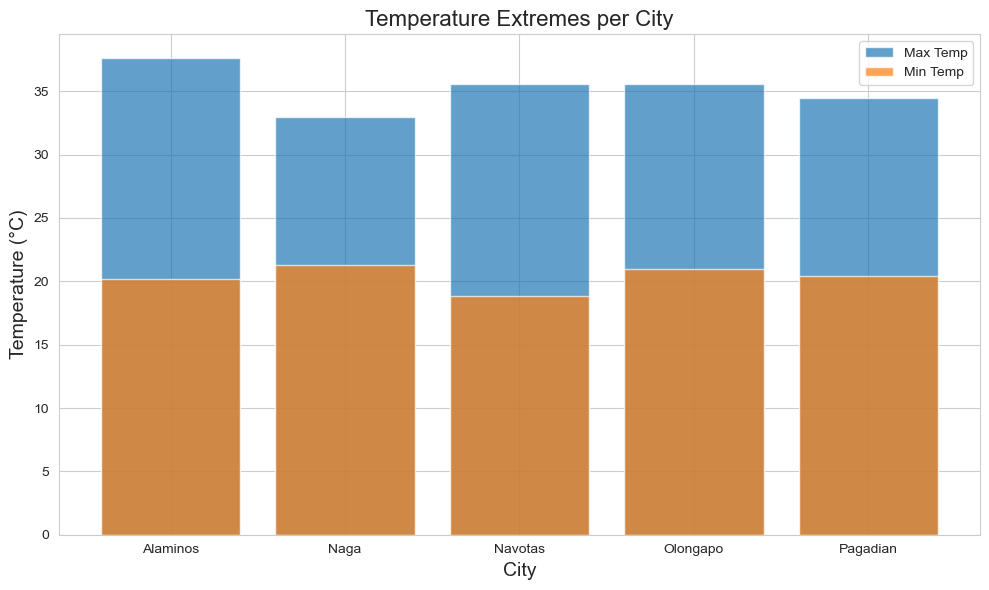

In [9]:
extremes = df[df['city_name'].isin(top_cities)].groupby('city_name').agg({
    'temperature_2m_max':'max',
    'temperature_2m_min':'min'
}).reset_index()

plt.figure(figsize=(10,6))
plt.bar(extremes['city_name'], extremes['temperature_2m_max'], alpha=0.7, label='Max Temp')
plt.bar(extremes['city_name'], extremes['temperature_2m_min'], alpha=0.7, label='Min Temp')
plt.title("Temperature Extremes per City", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.xlabel("City", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

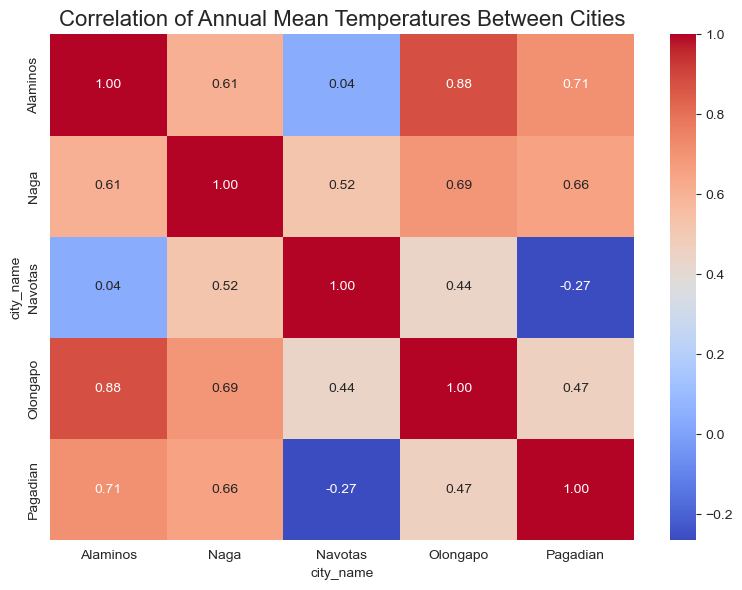

In [10]:
pivot_city = annual_city.pivot(index='year', columns='city_name', values='temperature_2m_mean')
corr_matrix = pivot_city.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Annual Mean Temperatures Between Cities", fontsize=16)
plt.tight_layout()
plt.show()

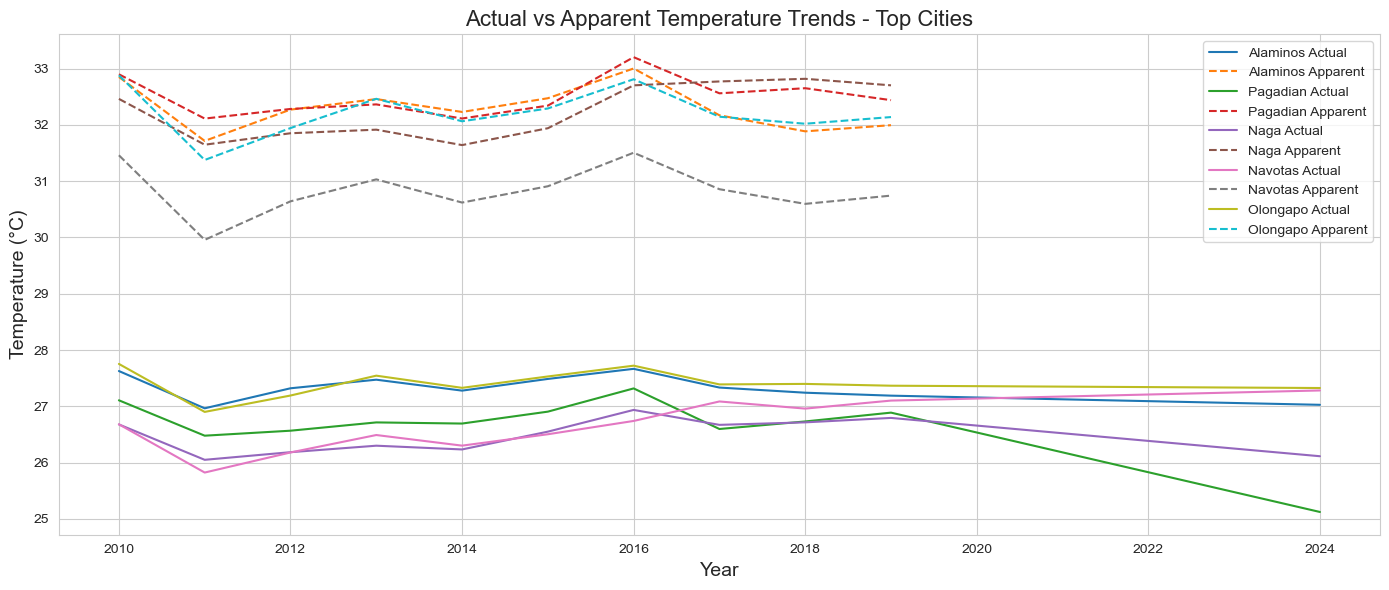

In [11]:
if 'apparent_temperature_max' in df.columns and 'apparent_temperature_min' in df.columns:
    df['apparent_temperature_mean'] = (df['apparent_temperature_max'] + df['apparent_temperature_min'])/2
    app_city = df[df['city_name'].isin(top_cities)].groupby(['year','city_name']).agg({
        'temperature_2m_mean':'mean',
        'apparent_temperature_mean':'mean'
    }).reset_index()
    
    plt.figure(figsize=(14,6))
    for city in top_cities:
        city_data = app_city[app_city['city_name']==city]
        plt.plot(city_data['year'], city_data['temperature_2m_mean'], label=f"{city} Actual")
        plt.plot(city_data['year'], city_data['apparent_temperature_mean'], linestyle='--', label=f"{city} Apparent")

    plt.title("Actual vs Apparent Temperature Trends - Top Cities", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Temperature (°C)", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
season_city.to_csv("../data/processed/phil_temp_city_seasonal_comparison.csv", index=False)
display(Markdown("City comparison results saved to `data/processed/phil_temp_city_seasonal_comparison.csv`"))
